In [5]:
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer
import torch
from PIL import Image
import matplotlib.pyplot as plt
import os
import numpy as np


In [6]:
class ViTGPT2CaptionGenerator:
    def __init__(self, model_name="nlpconnect/vit-gpt2-image-captioning"):

        print(f"Загрузка модели {model_name}...")
        self.model = VisionEncoderDecoderModel.from_pretrained(model_name)
        self.feature_extractor = ViTImageProcessor.from_pretrained(model_name)
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.model.to(self.device)
        print(f"Модель загружена. Используется устройство: {self.device}")
    
    def generate_caption(self, image_path, max_length=30, num_beams=4):
        """
        Генерация описания для изображения
        """
        image = Image.open(image_path)
        if image.mode != "RGB":
            image = image.convert(mode="RGB")
        
        pixel_values = self.feature_extractor(images=image, return_tensors="pt").pixel_values
        pixel_values = pixel_values.to(self.device)
        
        with torch.no_grad():
            output_ids = self.model.generate(
                pixel_values,
                max_length=max_length,
                num_beams=num_beams,
                early_stopping=True
            )
        
        # Декодирование
        caption = self.tokenizer.decode(output_ids[0], skip_special_tokens=True)
        return caption.strip()
    
    def generate_multiple_captions(self, image_paths, **kwargs):
        """Генерация описаний для нескольких изображений"""
        results = {}
        for path in image_paths:
            if os.path.exists(path):
                caption = self.generate_caption(path, **kwargs)
                results[path] = caption
                print(f"✓ {os.path.basename(path)}: {caption}")
            else:
                print(f"✗ Файл не найден: {path}")
        return results

In [7]:
def create_test_images():
    """Создание тестовых изображений, если их нет"""
    test_images = {
        "cat.jpg": (255, 200, 150),
        "landscape.jpg": (100, 150, 200),
        "car.jpg": (150, 150, 150),
    }
    
    created = []
    for name, color in test_images.items():
        if not os.path.exists(name):
            img_array = np.ones((300, 400, 3)) * color
            img_array = img_array.astype(np.uint8)
            noise = np.random.randint(-20, 20, img_array.shape)
            img_array = np.clip(img_array + noise, 0, 255).astype(np.uint8)
            plt.imsave(name, img_array)
            created.append(name)
    
    if created:
        print(f"Созданы тестовые изображения: {', '.join(created)}")


def visualize_results(image_paths, captions):
    """Визуализация изображений с подписями"""
    valid_paths = [p for p in image_paths if os.path.exists(p)]
    valid_captions = [captions[p] for p in valid_paths]
    
    if not valid_paths:
        print("Нет доступных изображений для визуализации")
        return
    
    n_images = len(valid_paths)
    fig, axes = plt.subplots(1, n_images, figsize=(5*n_images, 5))
    
    if n_images == 1:
        axes = [axes]
    
    for ax, img_path, caption in zip(axes, valid_paths, valid_captions):
        img = Image.open(img_path)
        ax.imshow(img)
        ax.set_title(caption, wrap=True, fontsize=10)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()


Найдены изображения: ['cat.jpg', 'french.jpg', 'car.jpg']
Загрузка модели nlpconnect/vit-gpt2-image-captioning...


Loading weights: 100%|██████████| 445/445 [00:00<00:00, 766.60it/s, Materializing param=encoder.pooler.dense.weight]                              
The tied weights mapping and config for this model specifies to tie decoder.transformer.wte.weight to decoder.lm_head.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning
VisionEncoderDecoderModel LOAD REPORT from: nlpconnect/vit-gpt2-image-captioning
Key                                                       | Status     |  | 
----------------------------------------------------------+------------+--+-
decoder.transformer.h.{0...11}.attn.bias                  | UNEXPECTED |  | 
decoder.transformer.h.{0...11}.crossattention.bias        | UNEXPECTED |  | 
decoder.transformer.h.{0...11}.crossattention.masked_bias | UNEXPECTED |  | 
decoder.transformer.h.{0...11}.attn.masked_bias           | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ign

Модель загружена. Используется устройство: cuda
Генерация описаний
✓ cat.jpg: a cat is sitting on the sidewalk near the road
✓ french.jpg: a black and white dog with a frisbee in its mouth
✓ car.jpg: a blue car is parked in a garage


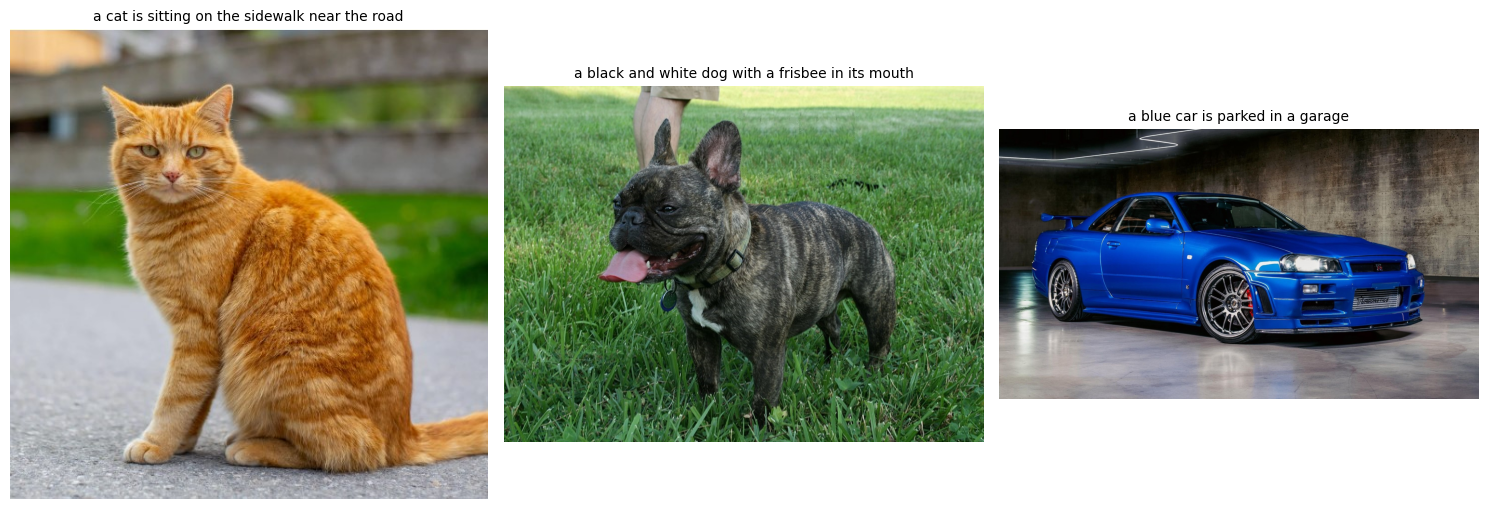

ИТОГОВЫЕ ОПИСАНИЯ:
cat.jpg: a cat is sitting on the sidewalk near the road
french.jpg: a black and white dog with a frisbee in its mouth
car.jpg: a blue car is parked in a garage


In [8]:
def main():
    create_test_images()
    
    image_paths = ["cat.jpg", "french.jpg", "car.jpg"]
    
    existing_files = [f for f in image_paths if os.path.exists(f)]
    if not existing_files:
        print("Ошибка: нет изображений для обработки!")
        return
    
    print(f"Найдены изображения: {existing_files}")
    
    generator = ViTGPT2CaptionGenerator()
    
    print("Генерация описаний")
    
    captions = generator.generate_multiple_captions(
        existing_files,
        max_length=30,
        num_beams=4
    )
    
    visualize_results(existing_files, captions)

    print("ИТОГОВЫЕ ОПИСАНИЯ:")
    for path, caption in captions.items():
        print(f"{os.path.basename(path)}: {caption}")


if __name__ == "__main__":
    main()